In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2023, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# define product groups and start times

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [4]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,5,12)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)
df.tail(5)

product         AP                                                        \
code            c1                                                         
field        close contract diff_oi      expiry    high     low      mth   
date                                                                       
2023-05-08  8631.0   AP2310 -3163.0  2023-10-20  8813.0  8621.0  24286.0   
2023-05-09  8616.0   AP2310 -2866.0  2023-10-20  8714.0  8552.0  24286.0   
2023-05-10  8656.0   AP2310 -1393.0  2023-10-20  8693.0  8586.0  24286.0   
2023-05-11  8482.0   AP2310 -8936.0  2023-10-20  8686.0  8470.0  24286.0   
2023-05-12  8474.0   AP2310 -5115.0  2023-10-20  8526.0  8408.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-05-08  8763.0     156472.0   0.0  146107.0  8485.0   AP2311  -931.0   
2023-05-09  8610.0     153606.0   0.0  134574.0  8469.0   AP2311  -492.0   
2023-05-10  8618.0     152213.0   0.0  116454.0  8499.0   AP2311  -156.0   
2023-05-11  8656.0     143277.0   0.0  149148.0  8326.0   AP2311   -44.0   
2023-05-12  8500.0     138162.0   0.0   96112.0  8325.0   AP2311     2.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-05-08  2023-11-14  8637.0  8482.0  24287.0  8613.0      10477.0   0.0   
2023-05-09  2023-11-14  8561.0  8417.0  24287.0  8477.0       9985.0   0.0   
2023-05-10  2023-11-14  8522.0  8435.0  24287.0  8474.0       9829.0   0.0   
2023-05-11  2023-11-14  8520.0  8326.0  24287.0  8489.0       9785.0   0.0   
2023-05-12  2023-11-14  8374.0  8272.0  24287.0  8366.0       9787.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2023-05-08  2226.0  15920.0   CF2309  -4507.0  2023-09-14  16065.0  15705.0   
2023-05-09   847.0  15600.0   CF2309 -12079.0  2023-09-14  15950.0  15535.0   
2023-05-10   593.0  15685.0   CF2309  -1422.0  2023-09-14  15830.0  15565.0   
2023-05-11   824.0  15620.0   CF2309 -13970.0  2023-09-14  15740.0  15565.0   
2023-05-12   737.0  15440.0   CF2309 -28824.0  2023-09-14  15605.0  15405.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-05-08  24285.0  16050.0     703938.0   0.0  945633.0  16185.0   CF2401   
2023-05-09  24285.0  15900.0     691860.0   0.0  761379.0  15890.0   CF2401   
2023-05-10  24285.0  15600.0     690438.0   0.0  690027.0  15960.0   CF2401   
2023-05-11  24285.0  15710.0     676436.0   0.0  572858.0  15890.0   CF2401   
2023-05-12  24285.0  15600.0     647617.0   0.0  612377.0  15720.0   CF2401   

product                                                             \
code                                                                 
field      diff_oi      expiry     high      low      mth     open   
date                                                                 
2023-05-08  2151.0  2024-01-12  16350.0  15980.0  24289.0  16350.0   
2023-05-09  9481.0  2024-01-12  16200.0  15820.0  24289.0  16145.0   
2023-05-10  5184.0  2024-01-12  16115.0  15845.0  24289.0  15880.0   
2023-05-11  -

In [5]:
for prodcode in sim_markets:
    if shift_mode == 1:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')]) - \
                                            np.log(df[(prodcode, 'c2', 'close')] - df[(prodcode, 'c2', 'shift')])
        df[(prodcode, 'c1', 'pct_chg')] = (df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')])/(df[(prodcode, 'c1', 'close')].shift(1) - df[(prodcode, 'c1', 'shift')]) - 1
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 0:
        df[(prodcode, 'c1', 'ryield')] = np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')])
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 2:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')]) - \
                                            df[(prodcode, 'c1', 'shift')] + df[(prodcode, 'c2', 'shift')]
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
    df[(prodcode, 'c1', 'ryield')] = df[(prodcode, 'c1', 'ryield')]/(df[(prodcode, 'c2', 'mth')] - df[(prodcode, 'c1', 'mth')])*12.0
adf = df.copy(deep=True)


C:\Users\harvey\AppData\Local\Temp/ipykernel_24064/332754688.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
C:\Users\harvey\AppData\Local\Temp/ipykernel_24064/332754688.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
C:\Users\harvey\AppData\Local\Temp/ipykernel_24064/332754688.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

# Calculate features

In [105]:
leadlag_portfolio = {
    'ferrous': {'lead': ['hc', 'rb', ],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', ],
                'param_rng': [40, 60, 2],
                },
    'constrs': {'lead': ['hc', 'rb', 'v'],
                'lag': ['FG', 'SA', 'v', 'UR', ],
                'param_rng': [40, 60, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF', ],
                'param_rng': [40, 60, 2],
                },
    'base': {'lead': ['al'],
             'lag': ['al', 'ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 60, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}


def lead_lag(df, input_args, leadlag_port=leadlag_portfolio):
    product_list = input_args['product_list']
    signal_cap = input_args.get('signal_cap', None)
    conv_func = input_args.get('conv_func', 'qtl')
    signal_df = pd.DataFrame(index=df.index, columns=product_list)
    for asset in product_list:
        for sector in leadlag_port:
            if asset in leadlag_port[sector]['lag']:
                signal_list = []
                for lead_prod in leadlag_port[sector]['lead']:
                    feature_ts = df[(lead_prod, 'c1', 'close')]
                    signal_ts = calc_conv_signal(feature_ts.dropna(), conv_func,
                                                 leadlag_port[sector]['param_rng'], signal_cap=signal_cap)
                    signal_list.append(signal_ts)
                signal_df[asset] = pd.concat(signal_list, axis=1).mean(axis=1)
                break
            else:
                signal_df[asset] = 0
    return signal_df

In [148]:
leadlag_repo = {
    'ferrous': {'lead': ['hc', 'rb',],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'SA', 'v', 'UR',],
                'param_rng': [40, 80, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF', 'al', 'cu', 'zn',],
                'param_rng': [40, 80, 2],
                },
#     'base0': {'lead': ['v'],
#              'lag': ['al', 'cu', 'zn',],  # 'zn', 'cu'
#              'param_rng': [40, 60, 2],
#              },
    'base': {'lead': ['al'],
             'lag': ['ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 80, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}

asset_list = [
    'rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'UR', 
    'sc', 'al', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI', 
]
input_args = {
    'product_list': asset_list,
    'conv_func': 'qtl',
    'signal_cap': None,
}
signal_df = lead_lag(df, input_args, leadlag_repo)

# signal_df = pd.DataFrame(index=df.index, columns=asset_list)
# for asset in asset_list:
#     signal_df[asset] = calc_conv_signal(df[(asset, 'c1', 'close')].dropna(), 'qtl', [40, 80, 2], signal_cap=None)
# signal_df


,rb,hc,i,j,jm,SM,FG,v,UR,sc,al,ni,sn,ss,TA,pp,eg,eb,p,y,OI
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-08,-0.717679,-0.717679,-0.717679,-0.752969,-0.858839,-0.576518,0.568281,-0.894129,-0.92942,-0.611808,-0.386735,0.396845,0.307792,0.411607,-0.031652,-0.92942,0.463261,-0.785661,-0.031901,-0.541228,-0.611808
2023-05-09,-0.788259,-0.717679,-0.788259,-0.858839,-0.929420,-0.717679,0.480519,-0.929420,-0.96471,-0.541228,-0.677227,0.109870,0.135897,0.373817,-0.174579,-0.96471,0.386692,-0.858839,-0.213864,-0.788259,-0.611808
2023-05-10,-0.823549,-0.788259,-0.647098,-0.858839,-0.894129,-0.788259,0.488495,-0.964710,-0.96471,-0.456768,-0.644534,0.039398,0.125377,0.535733,-0.305591,-0.96471,0.274773,-0.823549,-0.294197,-0.894129,-0.576518


portfolio sharpe:
%s
 sharpe       1.214576
sharpe_6m    0.432951
sharpe_1y    0.236418
sharpe_2y    0.566852
sharpe_3y    1.686572
sharpe_4y    1.424014
sharpe_5y    1.353294
sharpe_6y    1.172013
sharpe_7y    1.147500
sharpe_8y    1.240537
sharpe_9y    1.205829
Name: total, dtype: float64
asset sharpe:
%s
 product          rb        hc         i         j        jm        SM  \
sharpe     0.959918  1.117002  0.930061  1.185233  0.405284  0.084812   
sharpe_6m  1.585893  1.859263  1.617932  0.684901  1.183366 -0.664493   
sharpe_1y  1.083076  1.385011  0.191337 -0.015847  0.475434 -0.293442   
sharpe_2y -0.050748  0.390822  0.091719  0.118252  0.916233 -0.267673   
sharpe_3y  0.931417  1.646220  1.156191  0.623259  1.009009 -0.116306   
sharpe_4y  0.396634  1.044737  0.717429  0.200247  0.331853  0.110022   
sharpe_5y  0.576301  1.043771  0.760251  0.080372  0.035174  0.036906   
sharpe_6y  0.443927  0.820269  0.703434  0.238720  0.041186  0.120757   
sharpe_7y  0.384301  0.798123  0.

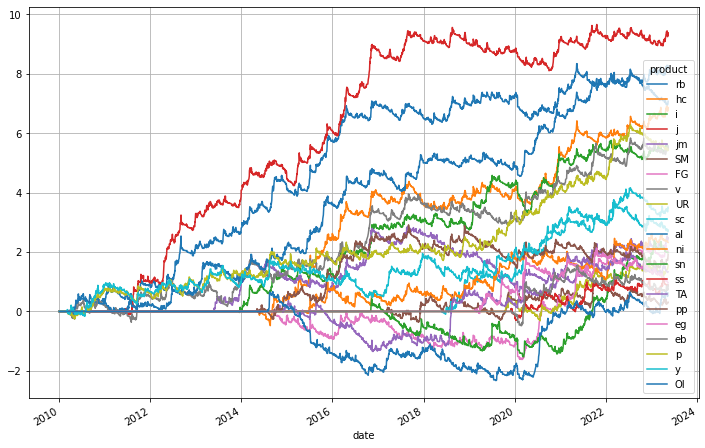

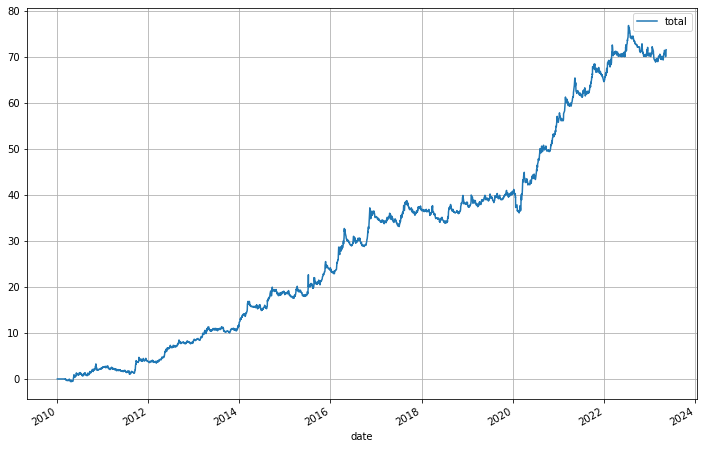

In [149]:
vol_win=20
vol_df = get_asset_vols(df, asset_list, vol_win=vol_win, vol_type='pct_chg')

holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=1.0,
                                       asset_scaling=False)
df_pxchg = get_px_chg(df, exec_mode='open', chg_type='pct', contract='c1')
df_pxchg = df_pxchg[asset_list].reindex(index=holding.index)

bt_metrics = MetricsBase(holdings=holding[asset_list],
                         returns=df_pxchg[asset_list])

pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors, perf_metrics=['sharpe', 'std'])
print('portfolio sharpe:\n%s\n', pnl_stats['sharpe'])
print('asset sharpe:\n%s\n', pnl_stats['asset_sharpe_stats'])
print('turnover: %s\n pnl_per_trade: %s\n' % (pnl_stats['turnover'], pnl_stats['pnl_per_trade']))

pnl_stats['asset_cumpnl'].plot()
plt.grid()
plt.show()
pnl_stats['portfolio_cumpnl'].plot()
plt.grid()
plt.show()
